In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Necessary Dependencies
import numpy as np 
import pandas as pd 
# !pip install utils
from keras.utils import *
from glob import glob
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from datetime import datetime
import statistics
from tqdm import tqdm
import tensorflow as tf
# DenseNet Dependencies
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Dense,Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, VGG16, ResNet50
from keras import backend as K
from tensorflow.keras import Sequential
import keras 
import matplotlib
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import roc_curve, auc
print('Started')

Started


In [3]:
path, dirs, files = next(os.walk("../input/brain-mri-data/Brain_Data_Organised/Train/Stroke"))
file_count = len(files)
print('Stroke:',file_count)
path, dirs, files = next(os.walk("../input/brain-mri-data/Brain_Data_Organised/Train/Normal"))
file_count = len(files)
print('Non-Stroke:',file_count)

Stroke: 825
Non-Stroke: 1426


In [4]:
image_size = (224, 224)
batch_size = 32

train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/brain-mri-data/Brain_Data_Organised/Train",
    validation_split=0.20,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/brain-mri-data/Brain_Data_Organised/Train",
    validation_split=0.2,
    subset="validation",
    seed=333,
    image_size=image_size,
    batch_size=batch_size,
)
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/brain-mri-data/Brain_Data_Organised/Test",
    image_size=image_size,
    batch_size=batch_size,
)

Found 2251 files belonging to 2 classes.
Using 1801 files for training.
Found 2251 files belonging to 2 classes.
Using 450 files for validation.
Found 250 files belonging to 2 classes.


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


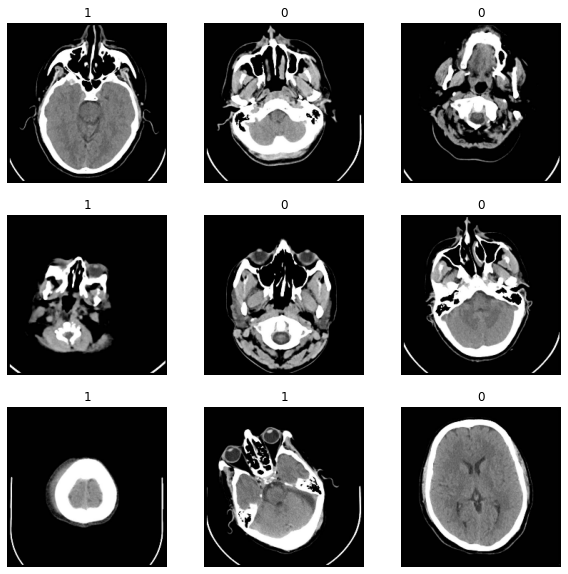

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=None, fill_mode='reflect',
        interpolation='bilinear', seed=None, fill_value=0.0),
                layers.experimental.preprocessing.RandomCrop(height= 224, width = 224, seed=None),
    ]
)

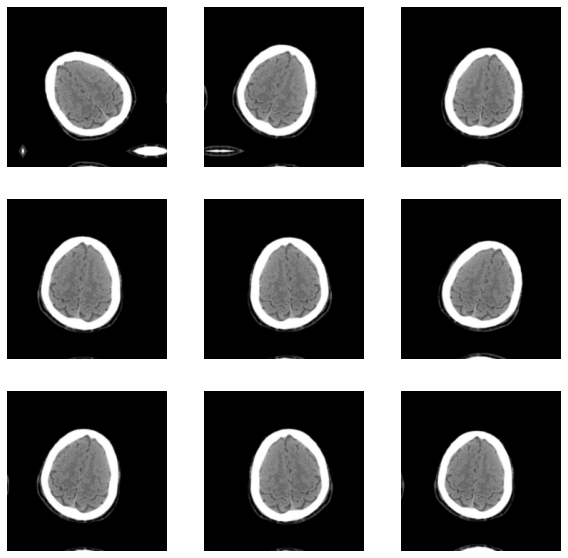

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_df.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
train_df = train_df.prefetch(buffer_size=32)
val_df = val_df.prefetch(buffer_size=32)

In [9]:
# Hyperparameters
IMG_IND=224
IMG_SHAPE = (IMG_IND,IMG_IND,3)
LOSS = BinaryCrossentropy() # Not un-weighted 
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

IMG_SIZE = (224, 224)
SEED = 2
BATCH_SIZE = 16

In [10]:
def get_callbacks(model_name):
    callbacks =[]
    tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0)
    callbacks.append(tensor_board)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.h5', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    callbacks.append(checkpoint)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto') 
    callbacks.append(anne)
    return callbacks

In [11]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = DenseNet121(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights(dire)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=METRICS)

29089792/29084464 [==============================] - 0s 0us/step


In [12]:
callbacks = get_callbacks('dense121')
history = model.fit( train_df,epochs=50,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/50
57/57 [==============================] - 55s 523ms/step - loss: 0.6963 - tp: 193.4310 - fp: 119.8103 - tn: 480.1897 - fn: 149.2241 - BinaryAccuracy: 0.6810 - precision: 0.5712 - recall: 0.5425 - auc: 0.6953 - val_loss: 19.2351 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 273.0000 - val_fn: 177.0000 - val_BinaryAccuracy: 0.6067 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000

Epoch 00001: val_loss improved from inf to 19.23505, saving model to model.dense121.h5
Epoch 2/50
57/57 [==============================] - 22s 372ms/step - loss: 0.2996 - tp: 288.7586 - fp: 57.0862 - tn: 540.7931 - fn: 56.0172 - BinaryAccuracy: 0.8802 - precision: 0.8312 - recall: 0.8450 - auc: 0.9408 - val_loss: 10.3694 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 273.0000 - val_fn: 176.0000 - val_BinaryAccuracy: 0.6089 - val_precision: 1.0000 - val_recall: 0.0056 - val_auc: 0.5085

Epoch 00002: val_loss improved from 19.23505 to 10.36943, saving model to model.dense121.

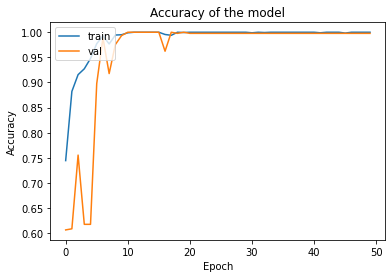

In [13]:
# Plot Accuracy and validation accuracy
plt.plot(history.history['BinaryAccuracy'])
plt.plot(history.history['val_BinaryAccuracy'])
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

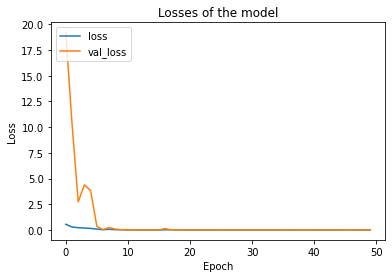

In [14]:
# Plot loss and val_loss accuarcy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Losses of the model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [15]:
results = model.evaluate_generator(test_df, steps=len(test_df), verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


8/8 [==============================] - 4s 300ms/step - loss: 0.2045 - tp: 117.0000 - fp: 7.0000 - tn: 118.0000 - fn: 8.0000 - BinaryAccuracy: 0.9400 - precision: 0.9435 - recall: 0.9360 - auc: 0.9832


In [16]:
print('DesnseNet121:')
print('---------------')
print("ACCURACY: ",(results[1]+results[3])/(results[1]+results[2]+results[3]+results[4]))
print("Binary Accuracy: ",(results[5]))
print("Precision: ",(results[6]))
print("Recall: ",(results[7]))
print("AUC: ",(results[8]))
print("F1 Score: ",(2*((results[6]*results[7])/((results[6]+results[7])))))


DesnseNet121:
---------------
ACCURACY:  0.94
Binary Accuracy:  0.9399999976158142
Precision:  0.9435483813285828
Recall:  0.9359999895095825
AUC:  0.9831680059432983
F1 Score:  0.9397590279961779


In [17]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.trainable = True
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid',name='Final')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.load_weights(dire)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=METRICS)

94773248/94765736 [==============================] - 1s 0us/step


In [18]:
callbacks = get_callbacks('resnet50')
history = model.fit( train_df,epochs=50,
                    validation_data= val_df,
                    callbacks=[callbacks])

Epoch 1/50
57/57 [==============================] - 35s 449ms/step - loss: 0.8272 - tp: 299.9483 - fp: 124.0172 - tn: 599.8276 - fn: 168.8621 - BinaryAccuracy: 0.7588 - precision: 0.7130 - recall: 0.6585 - auc: 0.8131 - val_loss: 780.1963 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 273.0000 - val_fn: 177.0000 - val_BinaryAccuracy: 0.6067 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000

Epoch 00001: val_loss improved from inf to 780.19629, saving model to model.resnet50.h5
Epoch 2/50
57/57 [==============================] - 21s 353ms/step - loss: 0.3717 - tp: 242.4138 - fp: 43.9655 - tn: 552.7931 - fn: 103.4828 - BinaryAccuracy: 0.8499 - precision: 0.8626 - recall: 0.7008 - auc: 0.9070 - val_loss: 2.3308 - val_tp: 110.0000 - val_fp: 80.0000 - val_tn: 193.0000 - val_fn: 67.0000 - val_BinaryAccuracy: 0.6733 - val_precision: 0.5789 - val_recall: 0.6215 - val_auc: 0.7189

Epoch 00002: val_loss improved from 780.19629 to 2.33082, saving model to model.resnet50.

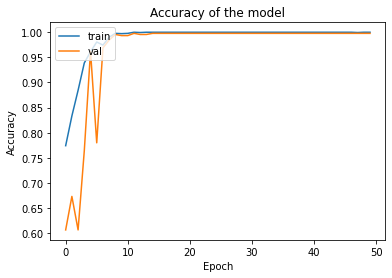

In [19]:
# Plot Accuracy and validation accuracy
plt.plot(history.history['BinaryAccuracy'])
plt.plot(history.history['val_BinaryAccuracy'])
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

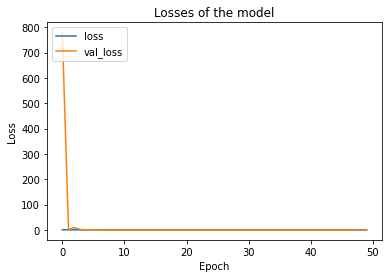

In [20]:
# Plot loss and val_loss accuarcy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Losses of the model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [21]:
results = model.evaluate_generator(test_df, steps=len(test_df), verbose=1)

8/8 [==============================] - 2s 177ms/step - loss: 0.3576 - tp: 108.0000 - fp: 8.0000 - tn: 117.0000 - fn: 17.0000 - BinaryAccuracy: 0.9000 - precision: 0.9310 - recall: 0.8640 - auc: 0.9592


In [22]:
print('Resnet50:')
print('---------------')
print(results[0])
print("ACCURACY: ",(results[1]+results[3])/(results[1]+results[2]+results[3]+results[4]))
print("Binary Accuracy: ",(results[5]))
print("Precision: ",(results[6]))
print("Recall: ",(results[7]))
print("AUC: ",(results[8]))
print("F1 Score: ",(2*((results[6]*results[7])/((results[6]+results[7])))))


Resnet50:
---------------
0.35759297013282776
ACCURACY:  0.9
Binary Accuracy:  0.8999999761581421
Precision:  0.931034505367279
Recall:  0.8640000224113464
AUC:  0.9591999053955078
F1 Score:  0.8962655827000016
